## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time


import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [9]:
x_df = pd.read_csv('../avg_base_wl_basic_28-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


,216.330000,216.370000,216.410000,216.450000,216.490000,216.520000,216.560000,216.600000,216.640000,216.680000,...,340.120000,340.150000,340.170000,340.200000,340.230000,340.260000,340.290000,340.320000,340.340000,340.370000
0,-34.080506,-52.856238,-53.531268,-50.722102,-46.480848,-48.353168,-43.511188,-42.930313,-25.964166,-13.178900,...,-103.397082,-27.768753,-23.160893,-9.626787,-19.266555,-49.249992,-57.284947,-42.332194,-19.901689,3.392399
1,-35.618919,-60.499509,-60.724984,-58.526364,-52.552160,-54.819421,-50.428250,-48.202075,-29.373010,-7.262829,...,-65.223663,25.026995,31.068621,53.714197,41.419173,-1.771897,-9.098835,12.655631,38.602063,69.219012
2,-62.382227,-84.498001,-82.950714,-81.565761,-74.436931,-77.430743,-70.423088,-64.868505,-43.506519,-21.451839,...,-93.318483,2.007907,0.898504,30.370624,11.331196,-23.058164,-25.353733,-3.266188,21.531311,46.794898
3,-49.101504,-80.148716,-83.607070,-77.709286,-63.839702,-69.958822,-68.338852,-63.386695,-29.598815,21.239889,...,-42.188972,93.573616,118.603411,177.033714,161.691056,82.310284,56.179137,97.075480,151.791278,221.938668
4,-35.597277,-58.723867,-60.834177,-57.003971,-51.635249,-52.753055,-50.356131,-46.890307,-24.775737,3.372683,...,-72.327183,24.663949,30.693258,61.472081,45.860159,-2.779950,-19.371852,6.021838,38.575199,85.071577
5,-36.534193,-59.580579,-59.810637,-55.192681,-50.080626,-51.567380,-51.542303,-46.489816,-26.755774,-1.753168,...,-85.625283,9.758146,12.955223,40.682918,23.893431,-20.144712,-35.420234,-11.428840,20.462124,59.212916
6,-37.056010,-62.295118,-62.219335,-58.452735,-52.370099,-54.861897,-52.544780,-48.673733,-25.452400,4.840277,...,-76.810026,30.638917,34.893883,73.356474,54.438559,1.259937,-14.633469,12.454864,50.428531,101.901342
7,-36.567012,-60.525560,-61.558858,-60.930587,-51.995660,-56.664018,-52.716117,-49.237293,-25.918533,0.284314,...,-81.835294,26.650759,25.292772,59.780565,40.039979,-9.963122,-25.816141,-0.461396,34.829779,80.718363
8,-36.352760,-66.482287,-70.130211,-67.015686,-56.367065,-60.704904,-57.048680,-55.251739,-29.179874,-1.546280,...,-79.287743,33.481820,49.192359,93.304922,84.044624,24.143615,7.073220,34.408659,76.490304,125.803008
9,-31.922748,-51.175660,-52.985698,-47.869829,-44.266964,-45.152212,-43.333262,-39.709429,-22.070866,0.327345,...,-78.304219,6.692097,4.575283,32.220340,18.928740,-18.095330,-29.613183,-6.082963,18.667277,53.660729


[[216.33]
 [216.37]
 [216.41]
 ...
 [340.32]
 [340.34]
 [340.37]]


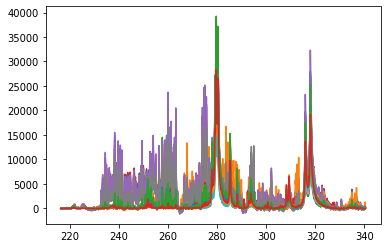

In [10]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("../data/H01.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""




In [11]:
df_y = pd.read_csv('../concentration.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
#y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 12)


,Sample,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2
0,H01,37.8,0.18,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03
1,H02,44.5,0.22,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07
2,H03,38.5,0.22,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86
3,H04,38.4,0.04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07
4,H05,43.2,0.18,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07
5,H06,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10
6,H07,46.1,0.25,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08
7,H08,45.1,0.19,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09
8,H09,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12
9,H10,42.4,0.24,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06


In [43]:
y_val = concentration[:,3] #3-Mg, 4-Al, 5-Si, 6-Fe, 7-Mn
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[25.0 18.0 21.1 15.5 17.1 15.9 14.3 13.0 10.6 19.3 11.2 17.4 7.9 7.9 9.6
 8.9 8.4 10.5 9.1 7.7 6.8 6.1 14.1 11.8 7.2 18.4 19.9 14.9 8.9 8.94 19.9
 14.0 20.0 24.4]
(34,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)
       0
6   14.3
7     13
13   7.9
1     18
4   17.1
24   7.2
22  14.1


# Principal Components Analysis

In [45]:
n_components=25


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(34, 3648)
(3648,)
34
(34, 25)
[58.   80.11 87.04 91.02 93.73 95.76 96.96 97.88 98.51 99.04 99.24 99.43
 99.6  99.7  99.77 99.82 99.86 99.9  99.93 99.95 99.96 99.97 99.98 99.99
 99.99]


In [46]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9192739043346322 -28.010890726982876
2.223773125986253 799.1670924729882


now using PCA with Linear regression and PLS

In [47]:
n_components=25

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(27, 3648)
(3648,)
27
(27, 25)
[ 57.6   82.03  87.58  92.31  94.67  96.1   97.34  98.23  98.83  99.27
  99.49  99.67  99.76  99.83  99.88  99.92  99.95  99.97  99.98  99.99
 100.   100.01 100.01 100.01 100.01]


In [48]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -6.630833874861764
MSE:  113.70876861365441


37% completed
Suggested number of components:  3



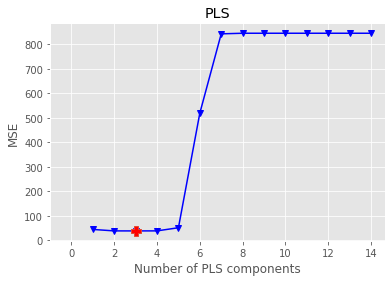

R2 calib: 0.999
R2 CV: -0.235
MSE calib: 0.038
MSE CV: 37.955


In [49]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [50]:
pls = PLSRegression(n_components=13)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -5.988127151011698
MSE:  104.13165144046329


# Linear Regression
this is ordinary least square regression

R^2_pred:  -0.8725269082555704
RMSE:  5.282323714341988 

[real, predictions]
[[14.3 23.430131604054466]
 [13.0 18.008149994132694]
 [7.9 8.961169780005294]
 [18.0 20.490781532750475]
 [17.1 17.503614113290134]
 [7.2 10.439607406919686]
 [14.1 22.400102580167882]]


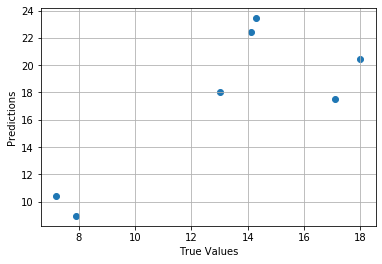

In [51]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [100]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(27, 3648) (27, 1)
(7, 3648) (7, 1)


,0
0,25
14,9.6
31,14
9,19.3
8,10.6
24,7.2
27,14.9


100% completed
Suggested number of components:  4



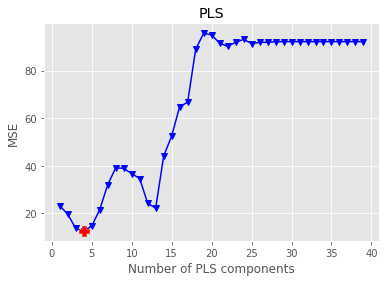

R2 calib: 0.770
R2 CV: 0.541
MSE calib: 6.326
MSE CV: 12.648


In [92]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [93]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv 0.21468135280949252
MSE:  21.63328337093525


100% completed
Suggested number of components:  4



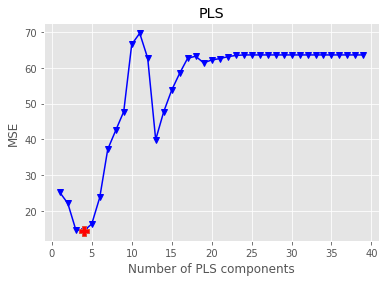

R2 calib: 0.768
R2 CV: 0.501
MSE calib: 6.719
MSE CV: 14.479


In [94]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.5452511610573683
R2_cv:  0.18012185566673633

TEST
 [real, predictions]
[[25.0 20.472635550145075]
 [9.6 8.056088756740701]
 [14.0 15.303861015192272]
 [19.3 21.280917470912076]
 [10.6 13.704998193977799]
 [7.2 11.217941561326999]
 [14.9 21.86609412676252]]



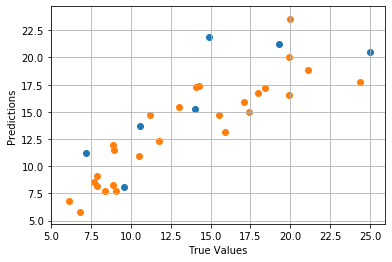

In [101]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [23]:
print(wl.shape)

(3648, 1)


## Wavelenght selection for PLS

In [60]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  3
Wavelengths to be discarded  2898
Optimised MSEP  8.3149245352438

--- 2718.446411371231 seconds ---


sorted wavelengths:  [[273.95 299.48 304.69 322.67 334.03 255.37 245.25 302.1  252.53 334.73]]


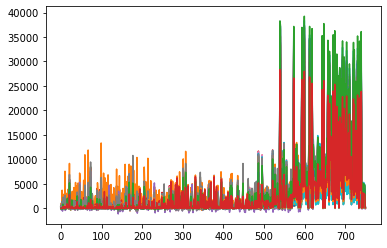

In [61]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [102]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 750) (27, 1)
(7, 750) (7, 1)
       0
27  14.9
19   7.7
1     18
28   8.9
2   21.1
20   6.8
12   7.9


In [103]:
#optimise_pls_cv(X_train,y_train, 3, plot_components=True)

R2_pred:  0.6232467942600319
RMSE:  3.827251897319096



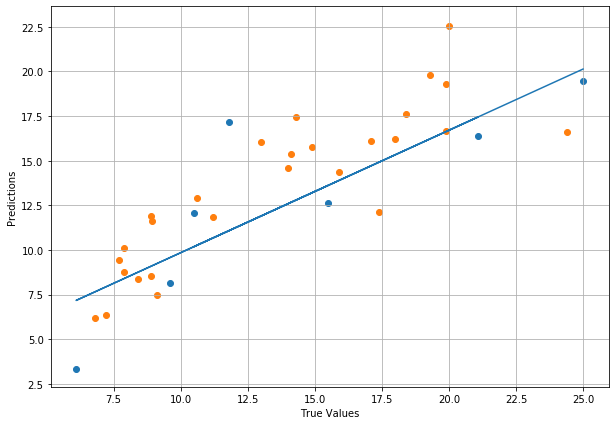

In [118]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [105]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(27, 750)
(7, 750)


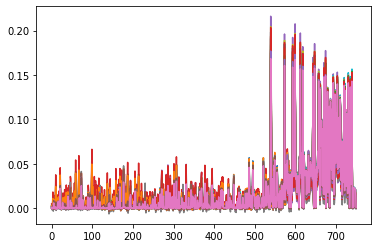

In [106]:
plt.plot(Xn_train.T)
plt.show()

In [107]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  0.7202102606130725
RMSE:  2.8197814797962573

TEST
 [real, predictions]
[[14.9 18.94218010053904]
 [7.7 7.188635597786872]
 [18.0 15.739655942100828]
 [8.9 10.874436383035802]
 [21.1 16.503229696236286]
 [6.8 9.423442908279037]
 [7.9 6.472710460253396]]



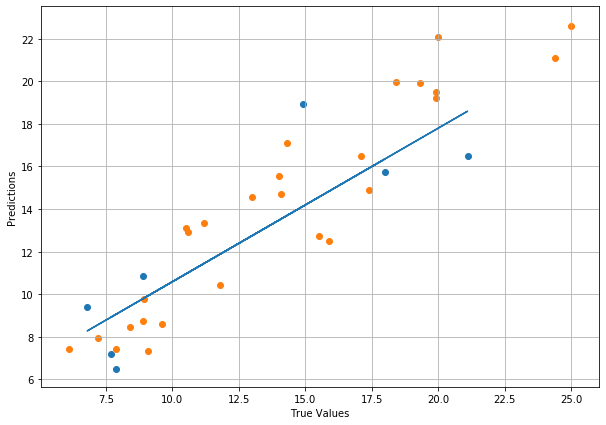

In [108]:
# Define PLS object
pls = PLSRegression(n_components=7)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [109]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

(27, 750)
(7, 750)


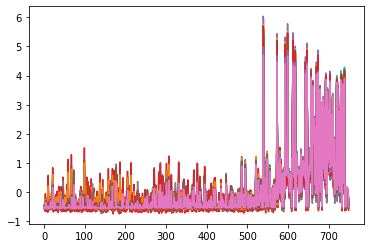

In [110]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  0.7775972404488015
RMSE:  2.514025322048061

TEST
 [real, predictions]
[[14.9 18.51455682465541]
 [7.7 7.264181859290526]
 [18.0 15.898602707338833]
 [8.9 11.046857657257288]
 [21.1 16.80687688816041]
 [6.8 5.061342846539489]
 [7.9 7.186836893804144]]



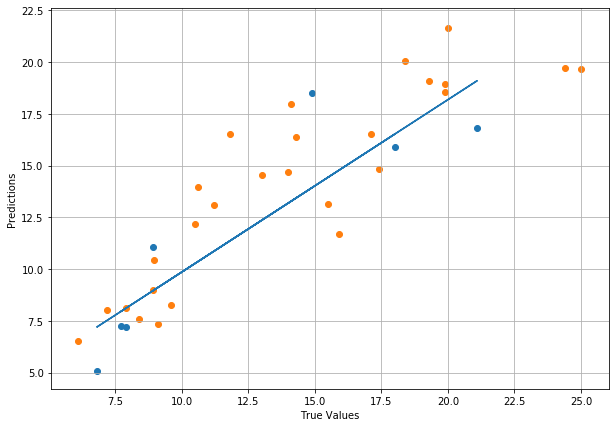

In [111]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

In [112]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 15, plot_components=True)

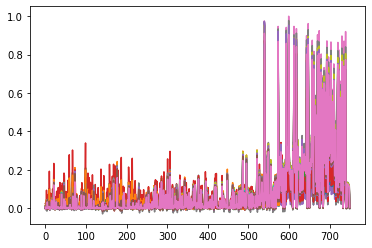

In [113]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  0.8354951025617094
RMSE:  2.1621657211628875

TEST
 [real, predictions]
[[14.9 18.03652363014002]
 [7.7 9.398476517702235]
 [18.0 16.764368808340866]
 [8.9 12.652003906923563]
 [21.1 19.125149639471324]
 [6.8 7.297205872540534]
 [7.9 8.400555582578473]]



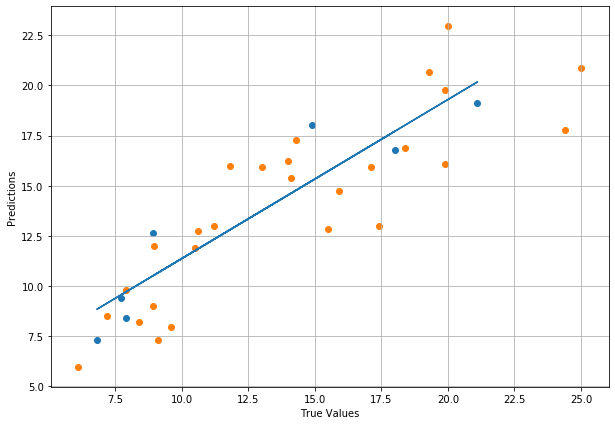

In [114]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [115]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)


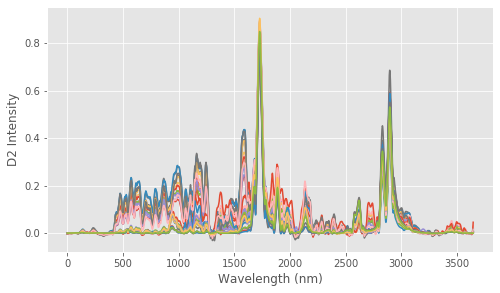

100% completed
Suggested number of components:  6



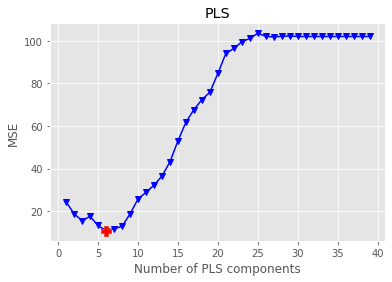

R2 calib: 0.834
R2 CV: 0.609
MSE calib: 4.571
MSE CV: 10.778


In [34]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  5



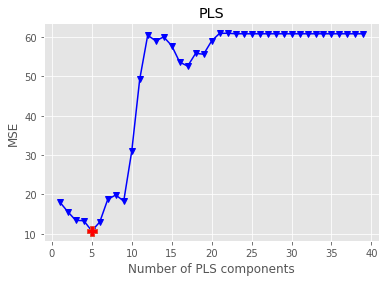

R2 calib: 0.852
R2 CV: 0.581
MSE calib: 3.787
MSE CV: 10.752


In [35]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  0.1649860006265983
R2_cv:  0.4927830298446778

[real, predictions]
[[15.9 10.770687549143025]
 [13.0 14.465004698889048]
 [7.2 -1.138163658934202]
 [9.1 3.8163457681246644]
 [25.0 19.962244678550732]
 [7.9 3.550324681147721]
 [17.4 11.62702744131783]]


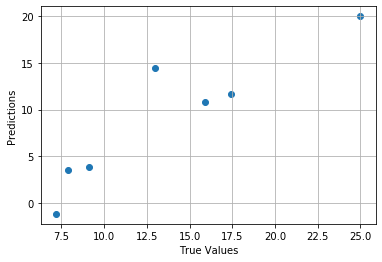

In [37]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [38]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [39]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.97, MSE:8.87, RMSE:2.98
Alpha:0.0010, R2:0.91, MSE:8.53, RMSE:2.92
Alpha:0.0100, R2:0.77, MSE:11.74, RMSE:3.43
Alpha:0.1000, R2:0.58, MSE:17.74, RMSE:4.21
Alpha:0.3000, R2:0.26, MSE:27.92, RMSE:5.28
Alpha:0.5000, R2:0.06, MSE:33.55, RMSE:5.79
Alpha:0.7000, R2:0.00, MSE:34.73, RMSE:5.89
Alpha:1.0000, R2:0.00, MSE:34.82, RMSE:5.90


In [40]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9745781713670396
RMSE:  2.9779539755657836
R^2:  0.7453097692192908


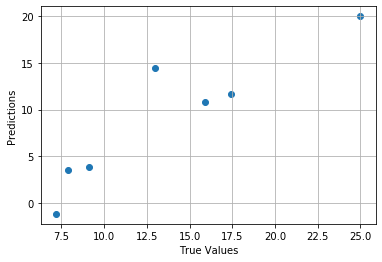

In [41]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [44]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(28, 20) (28, 1)
(6, 20) (6, 1)


In [45]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(6,)
(28,)


RMSE:  4.656149107864393
R^2:  0.29224213000392685 

[real, predictions]
[[8.94 11.94368000000031]
 [14.0 15.567280000000377]
 [19.9 16.690320000000337]
 [6.8 10.018600000000136]
 [21.1 11.722720000000184]
 [9.1 12.263079999999999]]


Text(0, 0.5, 'Predictions')

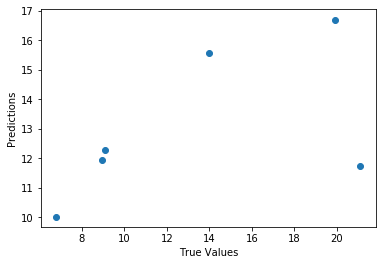

In [46]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

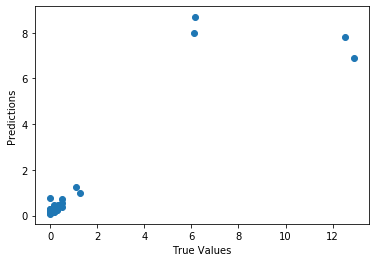

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



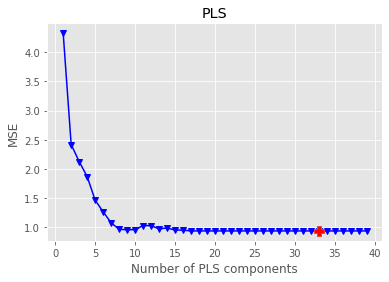

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
